In [5]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2
using DSP

In [44]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,6)
    r0[:,:,1] .= 5 .*(rand.())   # Cdc42-GTPm
    #r0[50,50,1] = 500
    r0[:,:,2] .= 0.5 - mean(r0[:,:,1])*n   # Cdc42-GDPm should be 0.5
    r0[:,:,3] .= 0
    r0[:,:,4] .= 10 .*(rand.())
    r0[:,:,5] .= 0 # no pak
    r0[:,:,6] .= 0.75
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    Dgef = zeros(N,N)
    Dpakc = zeros(N,N)
    Dgefc = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R)
    # Actual parameters
    a = .8
    b = .07
    c = 1
    d = .03 
    e = .04 
    f = .05 
    g = .025 
    Dm = .01
    Dc = 10
    Dm2 = .1
    n = n

    p = [a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy]
    return p, r0
end

setup (generic function with 1 method)

In [45]:
function simple!(dr,r,p,t)
    a, b, c, d, e, f, g, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    gef = @view r[:,:,4]
    pakc = @view r[:,:,5]
    gefc = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,gef)
    mul!(tAx,gef,Ax)
    @. Dgef = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,pakc)
    mul!(tAx,pakc,Ax)
    @. Dpakc = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,gefc)
    mul!(tAx,gefc,Ax)
    @. Dgefc = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*gef^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = d*rhoT*pakc - e*pak + Dpak
    @. dr[:,:,4] = f*rhoT*gefc - g*pak*gef - .1*gef + Dgef 
    @. dr[:,:,5] = n*(- d*rhoT*pakc + e*pak) + Dpakc
    @. dr[:,:,6] = n*(- f*rhoT*gefc + g*pak*gef + .1*gef) + Dgefc
end


simple! (generic function with 1 method)

In [46]:
function run_pde(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,800),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=1)
    return sol_simp
end

run_pde (generic function with 1 method)

In [ ]:
Random.seed!(1)
sol3 = run_pde(3)

220.77797287976946

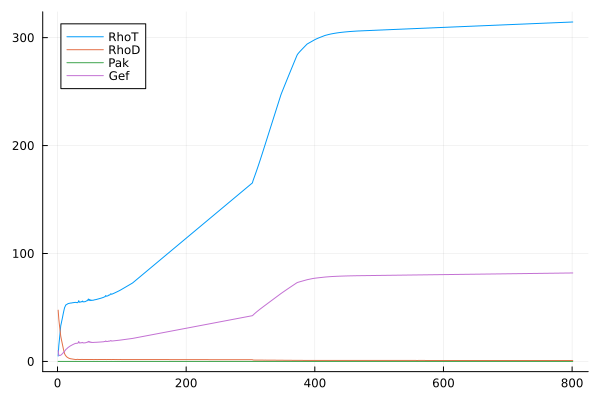

In [48]:
r=3
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V

T = dropdims(maximum(sol3[:,:,1,:], dims=(1,2)), dims = (1,2))[1:1:end]
D = dropdims(maximum(sol3[:,:,2,:], dims=(1,2)), dims = (1,2))./n
P = dropdims(maximum(sol3[:,:,3,:], dims=(1,2)), dims = (1,2))
G = dropdims(maximum(sol3[:,:,4,:], dims=(1,2)), dims = (1,2))
print(mean(T))
plot(T, label="RhoT")
plot!(D, label="RhoD")
plot!(P, label="Pak")
plot!(G, label="Gef")
#plot!(T+D)
#plot!(D, label="RhoD")



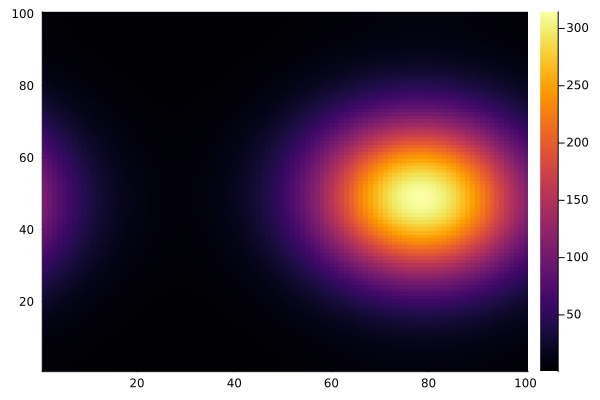

In [51]:
Plots.heatmap(sol3[:,:,1,end])

┌ Info: Saved animation to /tmp/jl_gPmbk7IJUV.gif
└ @ Plots /home/dionsaur/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_gPmbk7IJUV.gif")
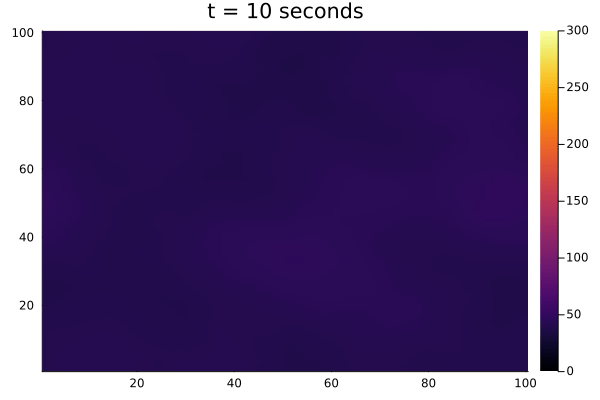

In [52]:
anim = @animate for i in 1:80
    Plots.heatmap(sol3[:,:,1,i*10], clim=(0,300), title="t = $(i*10) seconds")
end
gif(anim, fps=5)
#gif(anim, "tmp_negFB_r5.gif", fps=60)

In [61]:
function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r^2
    V = (4/3)*pi*r^3
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,6)
    r0[:,:,1] .= 5 .*(rand.())   # Cdc42-GTPm
    #r0[50,50,1] = 500
    r0[:,:,2] .= 0.5 - mean(r0[:,:,1])*n   # Cdc42-GDPm should be 0.5
    r0[:,:,3] .= 1
    r0[:,:,4] .= 10 .*(rand.())
    r0[:,:,5] .= 1
    r0[:,:,6] .= 0.75
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    Dpak = zeros(N,N)
    Dgef = zeros(N,N)
    Dpakc = zeros(N,N)
    Dgefc = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R)
    # Actual parameters
    a = .8
    b = .07
    c = 1
    d = .05
    e = .032
    f = .1
    g = .025 
    h = 0.1
    Dm = .01
    Dc = 10
    Dm2 = .1
    n = n

    p = [a, b, c, d, e, f, g, h, Dm, Dc, Dm2, n, Ax, Ay, dummy]
    return p, r0
end

setup (generic function with 1 method)

In [62]:
function simple!(dr,r,p,t)
    a, b, c, d, e, f, g, h, Dm, Dc, Dm2, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, Dpak, Dgef, Dpakc, Dgefc, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    pak = @view r[:,:,3]
    gef = @view r[:,:,4]
    pakc = @view r[:,:,5]
    gefc = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,pak)
    mul!(tAx,pak,Ax)
    @. Dpak = Dm2*(Ayt + tAx)
    mul!(Ayt,Ay,gef)
    mul!(tAx,gef,Ax)
    @. Dgef = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,pakc)
    mul!(tAx,pakc,Ax)
    @. Dpakc = Dc*(Ayt + tAx)
    mul!(Ayt,Ay,gefc)
    mul!(tAx,gefc,Ax)
    @. Dgefc = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*gef^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
    @. dr[:,:,3] = d*rhoT*pakc - e*pak + Dpak
    @. dr[:,:,4] = f*rhoT*gefc - g*pak*gef - h*gef + Dgef 
    @. dr[:,:,5] = n*(- d*rhoT*pakc + e*pak) + Dpakc
    @. dr[:,:,6] = n*(- f*rhoT*gefc + g*pak*gef + h*gef) + Dgefc
end


simple! (generic function with 1 method)

In [ ]:
Random.seed!(1)
sol3 = run_pde(3)

In [ ]:
r=3
SA = 4*pi*r^2
V = (4/3)*pi*r^3
mem_thickness = 0.01
n = (mem_thickness * SA) / V

T = dropdims(maximum(sol3[:,:,1,:], dims=(1,2)), dims = (1,2))[1:1:end]
D = dropdims(maximum(sol3[:,:,2,:], dims=(1,2)), dims = (1,2))./n
P = dropdims(maximum(sol3[:,:,3,:], dims=(1,2)), dims = (1,2))
G = dropdims(maximum(sol3[:,:,4,:], dims=(1,2)), dims = (1,2))
print(mean(T))
plot(T, label="RhoT")
plot!(D, label="RhoD")
plot!(P, label="Pak")
plot!(G, label="Gef")

In [ ]:
Plots.heatmap(sol3[:,:,1,end])

In [63]:
p, r0 = setup(3)
for i in range(1,10)
    Random.seed!(1)
    p, r0 = setup(3)
    p[i] = p[i]*1.25
    min_prob = ODEProblem(simple!,r0,(0.0,900),p)
    sol = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=5)
    T = dropdims(maximum(sol[:,:,1,:], dims=(1,2)), dims = (1,2))
    P = dropdims(maximum(sol[:,:,3,:], dims=(1,2)), dims = (1,2))
    G = dropdims(maximum(sol[:,:,4,:], dims=(1,2)), dims = (1,2))
    nmax = length(findlocalmaxima(sol[:,:,1,end], edges=false))
    plot(T)
    plot!(G)
    plot!(P)
    savefig("../negsims/sim_p$(i)_1p25_$(nmax)patch.png")
    Random.seed!(1)
    p, r0 = setup(3)
    p[i] = p[i]*0.8
    min_prob = ODEProblem(simple!,r0,(0.0,900),p)
    sol = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=5)
    T = dropdims(maximum(sol[:,:,1,:], dims=(1,2)), dims = (1,2))
    P = dropdims(maximum(sol[:,:,3,:], dims=(1,2)), dims = (1,2))
    G = dropdims(maximum(sol[:,:,4,:], dims=(1,2)), dims = (1,2))
    nmax = length(findlocalmaxima(sol[:,:,1,end], edges=false))
    plot(T)
    
    plot!(G)
    plot!(P)
    savefig("../negsims/sim_p$(i)_0p8_$(nmax)patch.png")
end

In [ ]:
for i in 1:100
    Random.seed!(1)
    p, r0 = setup(3)
    p[i] = p[i]*1.25
    min_prob = ODEProblem(simple!,r0,(0.0,900),p)
    sol = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=5)
    pdg = DSP.Periodograms.periodogram(T)
    plot(1 ./ pdg.freq[3:end], pdg.power[3:end])
    